In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

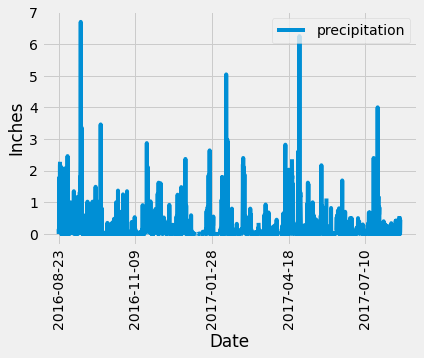

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') \
                    - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp, columns=['Date', 'precipitation'])
df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks(rotation='vertical')
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_prcp = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()
all_prcp_df = pd.DataFrame(all_prcp, columns=['Date', 'Prcp'])
all_prcp_df.describe()

,Prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [16]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations available in this dataset")

There are 9 stations available in this dataset


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
station_temp_data = session.query(*sel).filter(Measurement.station=='USC00519281').all()
station_temp_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
last_tob_date = session.query(Measurement.date).\
    filter(Measurement.station=='USC00519281').\
    order_by(Measurement.date.desc()).first()
one_year_tob = (dt.datetime.strptime(last_tob_date[0],'%Y-%m-%d') \
                    - dt.timedelta(days=365)).strftime('%Y-%m-%d')

tob_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date <= last_tob_date[0]).\
    filter(Measurement.date >= one_year_tob).\
    filter(Measurement.station == 'USC00519281').all()

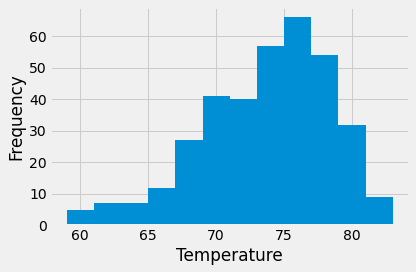

In [21]:
# Plot the above results as a histogram
tob_df = pd.DataFrame(tob_data, columns=['Date', 'Temperature'])
tob_df.set_index('Date', inplace=True)

tob_df.hist(bins=12)
plt.title("")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [23]:
# Identify the average temperature in June & Dec at all stations across all available years in the dataset
june_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date.like('____-06%')).all()
dec_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date.like('____-12%')).all()

[('2010-06-01', 78.0),
 ('2010-06-02', 76.0),
 ('2010-06-03', 78.0),
 ('2010-06-04', 76.0),
 ('2010-06-05', 77.0),
 ('2010-06-06', 78.0),
 ('2010-06-07', 77.0),
 ('2010-06-08', 78.0),
 ('2010-06-09', 78.0),
 ('2010-06-10', 79.0),
 ('2010-06-11', 78.0),
 ('2010-06-12', 78.0),
 ('2010-06-13', 78.0),
 ('2010-06-14', 77.0),
 ('2010-06-15', 78.0),
 ('2010-06-16', 78.0),
 ('2010-06-17', 77.0),
 ('2010-06-18', 77.0),
 ('2010-06-19', 82.0),
 ('2010-06-20', 78.0),
 ('2010-06-21', 78.0),
 ('2010-06-22', 78.0),
 ('2010-06-23', 78.0),
 ('2010-06-24', 78.0),
 ('2010-06-25', 77.0),
 ('2010-06-26', 76.0),
 ('2010-06-27', 78.0),
 ('2010-06-28', 78.0),
 ('2010-06-29', 78.0),
 ('2010-06-30', 78.0),
 ('2011-06-01', 77.0),
 ('2011-06-02', 78.0),
 ('2011-06-03', 73.0),
 ('2011-06-04', 70.0),
 ('2011-06-05', 76.0),
 ('2011-06-06', 77.0),
 ('2011-06-07', 77.0),
 ('2011-06-08', 77.0),
 ('2011-06-09', 77.0),
 ('2011-06-10', 78.0),
 ('2011-06-11', 77.0),
 ('2011-06-12', 77.0),
 ('2011-06-13', 78.0),
 ('2011-06-

In [35]:
# Create lists of tobs in June and Dec
june_tobs_list = []
for tob in june_tobs:
    june_tobs_list.append(tob.tobs)
        
dec_tobs_list = []
for tob in dec_tobs:
    dec_tobs_list.append(tob.tobs)

# Use the unpaired t-test to determine whether the difference in the means, if any, is statistically significant.
stats.ttest_ind(june_tobs_list, dec_tobs_list)


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

###### p-value 3.90e-191 < 0.05 .: We can reject the null hypothesis and claim the data is statistically significant

### Temperature Analysis II

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
hawaii_trip = calc_temps('2017-06-07', '2017-06-13')

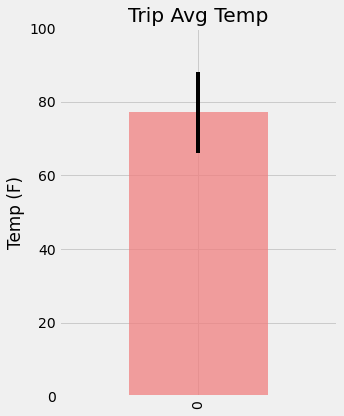

In [175]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(hawaii_trip, columns=['TMIN','TAVG','TMAX'])
y_err = df['TMAX'] - df['TMIN']

plt.figure(figsize=(5, 6))
plt.ylim(0,100)
plt.ylabel('Temp (F)')
df['TAVG'].plot(kind='bar', yerr=y_err, title='Trip Avg Temp', color='lightcoral',alpha=0.75)
plt.tight_layout()


### Daily Rainfall Average

In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_per_station = session.query(Measurement.station, func.sum(Measurement.prcp),\
    Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date>='2017-06-07').filter(Measurement.date<='2017-06-13').\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
prcp_per_station

[('USC00516128',
  19.529999999999998,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519281', 16.74, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  10.169999999999993,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00513117',
  9.360000000000005,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519523',
  4.950000000000001,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397', 1.26, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [80]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [162]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
trip_start = dt.datetime.strptime('2017-06-07', '%Y-%m-%d')
trip_end = dt.datetime.strptime('2017-06-13', '%Y-%m-%d')

# Use the start and end date to create a range of dates
date_range = [trip_start + dt.timedelta(days=x) for x in range(0, (trip_end-trip_start).days+1)]

# Stip off the year and save a list of %m-%d strings
date_list = []
for date in date_range:
    date_list.append(date.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []
for date in date_list:
    daily_norms.append(list(np.ravel(daily_normals(date))))
daily_norms

[[68.0, 75.07142857142857, 81.0],
 [70.0, 75.58620689655173, 81.0],
 [69.0, 75.15254237288136, 81.0],
 [68.0, 75.14285714285714, 81.0],
 [69.0, 76.01960784313725, 84.0],
 [66.0, 75.66666666666667, 83.0],
 [68.0, 75.66666666666667, 81.0]]

In [167]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms_df = pd.DataFrame(daily_norms, columns=['TMIN','TAVG','TMAX'])
norms_df['Date'] = date_list
norms_df.set_index('Date', inplace=True)
norms_df

,TMIN,TAVG,TMAX
Date,,,
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0


Text(0, 0.5, 'Temperature')

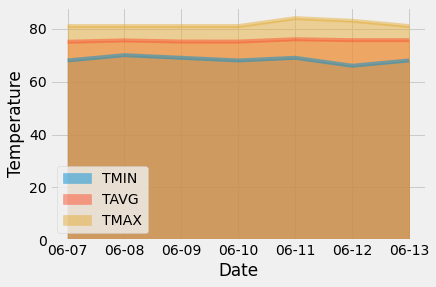

In [173]:
# Plot the daily normals as an area plot with `stacked=False`
norms_df.plot.area(stacked=False)
plt.ylabel('Temperature')